2602191301 - Allin Setiawan

Jelaskan cara kerja dari arsitektur tersebut yang dideskripsikan dalam gambar dibawah ini:
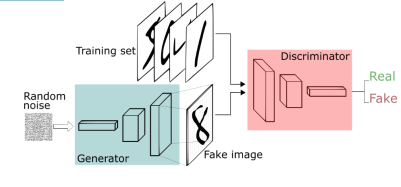

**Random noise** bakal masuk kedalam **Generator** yang berfungsi untuk menghasilkan data baru yang mirip dengan data aslinya lalu data baru yang dihasilkan generator akan dimasukkan ke dalam **Discriminator** yang berfungsi untuk membedakan antara data asli dan data palsu yang dihasilkan oleh generator tadi. Dari proses diatas saya bisa simpulkan bahwa proses GAN ada dua langkah yaitu pada **Generator dan Discriminator**. proses ini akan terus berulang-ulang dan dengan seiringnya waktu si generator akan semakin jago menghasilkan data yang mirip dengan data asli dan discriminator semakin jago membedakan antara data asli dan data palsu.

# **Import Dataset Fashion Mnist**

In [ ]:
!unzip '/content/t10k-images-idx3-ubyte.zip'
!unzip '/content/train-images-idx3-ubyte.zip'
!unzip '/content/train-labels-idx1-ubyte.zip'
!unzip '/content/t10k-labels-idx1-ubyte.zip'

Archive:  /content/t10k-images-idx3-ubyte.zip
  inflating: t10k-images-idx3-ubyte  
Archive:  /content/train-images-idx3-ubyte.zip
  inflating: train-images-idx3-ubyte  
Archive:  /content/train-labels-idx1-ubyte.zip
  inflating: train-labels-idx1-ubyte  
Archive:  /content/t10k-labels-idx1-ubyte.zip
  inflating: t10k-labels-idx1-ubyte  


In [ ]:
!pip install idx2numpy
import idx2numpy

x_train = idx2numpy.convert_from_file('train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('train-labels-idx1-ubyte')

x_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=c052d4c37122aeea43ccd3d67b8d0a2f6b3d66076e9ba0f8e430c217dea84089
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


# **Preprocessing and Scaling Dataset**

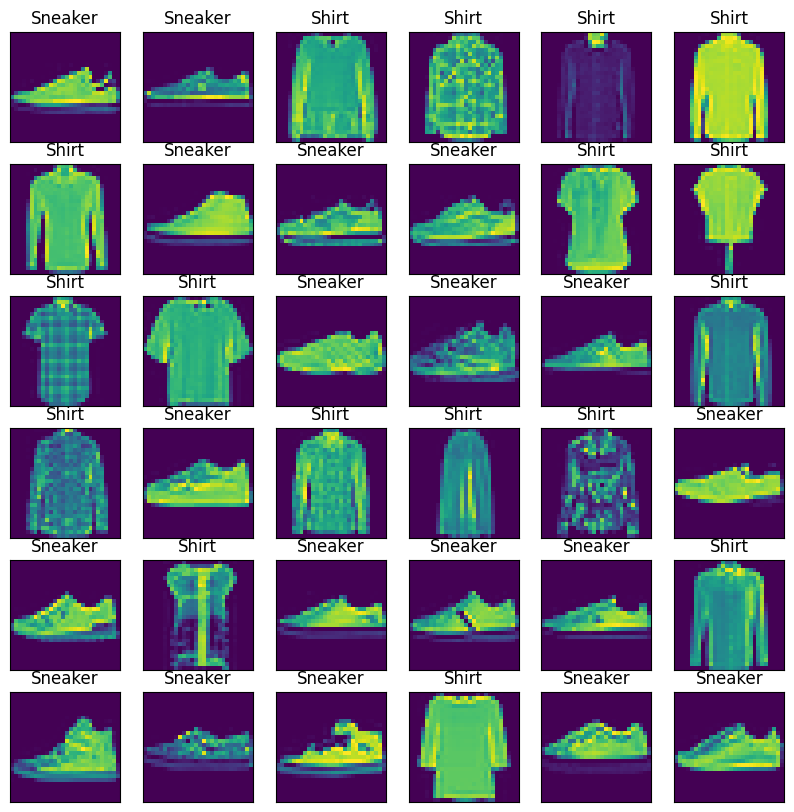

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Sesuai dengan soal mengambil label 'shirt' dan 'sneaker' untuk dataset ini
classes_of_interest = ['Shirt', 'Sneaker']
original_labels = [6, 7] #shirt = 6, sneaker = 7

mask = np.isin(y_train, original_labels)

# Filter pada training data
x_train_filtered = x_train[mask]
y_train_filtered = y_train[mask]

# Melakukan Mapping dari original labels ke new labels (0 for 'Shirt', 1 for 'Sneaker')
mapping = {6: 0, 7: 1}
y_train_filtered = np.array([mapping[label] for label in y_train_filtered])

class_names = ['Shirt', 'Sneaker']

plt.figure(figsize=(10, 10))
for i in range(min(36, len(x_train_filtered))):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_filtered[i].reshape((28,28)))
    label_index = int(y_train_filtered[i])
    plt.title(class_names[label_index])
plt.show()

Saya membuat class baru untuk model GAN ini dikarenakan pada soal kelas yang diberikan hanya 'shirt' dan 'sneakers'

In [ ]:
#Scaling Dataset
x_train_filtered = x_train_filtered.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Melakukan split data training 80% dan remaining untuk (validation dan test)
x_train, x_remaining, y_train, y_remaining = train_test_split(
    x_train_filtered, y_train_filtered, test_size=0.2, random_state=42
)

# Melakukan split data remaining dibagi menjadi ke test dan validation
x_val, x_test, y_val, y_test = train_test_split(
    x_remaining, y_remaining, test_size=0.5, random_state=42
)

In [ ]:
print("Train shapes:", x_train.shape, y_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape)
print("Test shapes:", x_test.shape, y_test.shape)

Train shapes: (9600, 28, 28) (9600,)
Validation shapes: (1200, 28, 28) (1200,)
Test shapes: (1200, 28, 28) (1200,)


# **Model GAN**

Membuat generator model sesuai dengan arsitektur model GAN pada umumnya

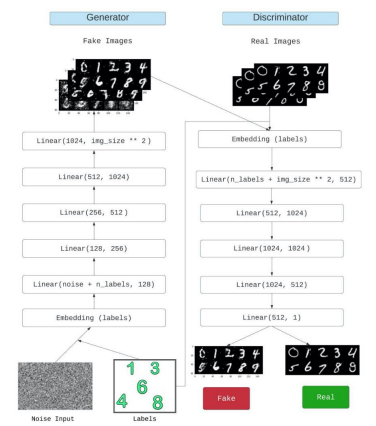

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model arsitektur diatas adalah code dari gambar yang sebelumnya(yang diminta soal). Dalam generator model ada layer dense dengan unit yang berbeda-beda tiap blocknya, lalu ada BatchNormalization yang digunakan untuk mempercepat konvergenti dan mencegah overfitting serta dapat memungkinkan penggunaan learning rate yang tinggi, lalu ada Conv2DTranspose yang digunkaan untuk meningkatkan resolusi data dan yang terakhir ada LeakyReLU itu aktivasi yang digunakan untuk mencegah adanya "Dying ReLU" dimana neuron berhenti karena adanya input negatif terus menerus lalu untuk memperlancar backpropagation

In [ ]:
generate = generator_model()
generate.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

Memberikan noise pada gambar yang akan di generate nantinya oleh model

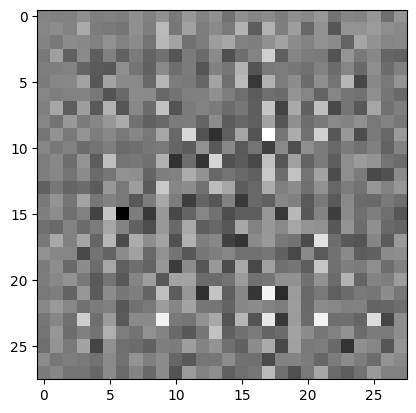

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generate(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Membuat model discriminator untuk menjadi penilai mengenai gambar tersebut. Jadi nantinya discriminator inilah yang membedakan antara gambar asli dan gambar buatan

In [51]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [52]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.02012704]], shape=(1, 1), dtype=float32)


In [53]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

Menggunakan Binary Crossentropy dikarenakan saya ingin melihat probabilitas output dari generator tersebut dan distribusi targetnya cuma ada 2 yaitu 1 untuk gambar nyata dan 2 untuk gambar palsu

In [54]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generate_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [55]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [56]:
import tensorflow as tf

BATCH_SIZE = 32
noise_dim = 100

def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer,
              generate_loss, discriminator_loss):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generate_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


In [57]:
import time
from IPython import display # Import the IPython display module

def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, generate_loss, discriminator_loss): # Added the missing arguments
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer, generate_loss, discriminator_loss) # Pass the arguments to train_step

    # Produce images for the GIF as you go
    display.clear_output(wait=True) # Now refers to the correct display object
    generate_and_save_images(generate,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generate,
                           epochs,
                           seed)

In [58]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generate,
                                 discriminator=discriminator)

In [59]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [60]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_filtered).shuffle(1000).batch(batch_size)

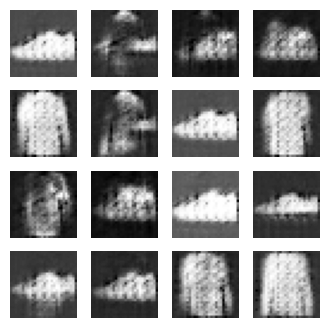

In [61]:
EPOCHS = 25
# Assuming you have defined generator, discriminator, etc.
train(train_dataset, EPOCHS, generate, discriminator, generator_optimizer, discriminator_optimizer, generate_loss, discriminator_loss) # Pass the arguments when calling train

Dari hasil generate diatas, model dapat melakukan generate image dengan baik. walaupun pada gambar diatas tidak terlalu begitu jelas dikarena hasil gambar hanya berasal dari 25 epochs saja sedangkan untuk menghasilkan gambar generate yang baik butuh banyak epoch yang dilakukan

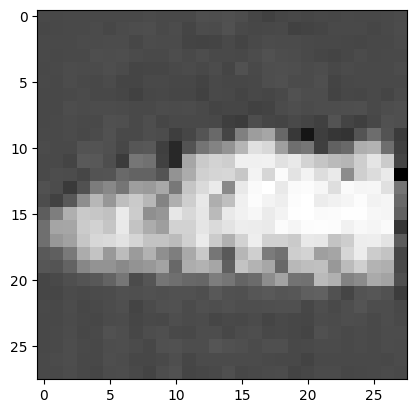

In [62]:
noise = tf.random.normal([1, 100])
generated_image = generate(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# **Evaluate With FID**

Skor FID digunakan untuk mengevaluasi kualitas gambar yang dihasilkan oleh jaringan permusuhan generatif, dan skor yang lebih rendah telah terbukti berkorelasi baik dengan gambar berkualitas lebih tinggi. Untuk melihat interpretasi nilai score FID:
* FID 0: Dua gambar identik.
* FID < 5: Dua gambar sangat mirip dan hampir tidak dapat dibedakan oleh manusia.
* FID 5 - 20: Dua gambar mirip, tetapi beberapa perbedaan mungkin terlihat oleh manusia yang jeli.
* FID 20 - 50: Dua gambar memiliki beberapa kesamaan, tetapi perbedaannya cukup jelas terlihat.
* FID > 50: Dua gambar sangat berbeda dan tidak mungkin dianggap sebagai representasi yang sama.



In [63]:
import os
import matplotlib.pyplot as plt

# Membuat Directory untuk real images
real_images_dir = 'real_test_images'
os.makedirs(real_images_dir, exist_ok=True)
for i, image in enumerate(x_test):
    plt.imsave(os.path.join(real_images_dir, f'image_{i}.png'), image, cmap='gray')

In [64]:
import os
import matplotlib.pyplot as plt

# Membuat directory generated images
generated_images_dir = 'generated_images'
os.makedirs(generated_images_dir, exist_ok=True)
num_images_to_generate = len(x_test)
noise = tf.random.normal([num_images_to_generate, 100])
generated_images = generate(noise, training=False)

for i, image in enumerate(generated_images):
    plt.imsave(os.path.join(generated_images_dir, f'generated_image_{i}.png'), image[:,:,0], cmap='gray')

In [65]:
!pip install pytorch-fid

In [66]:
from pytorch_fid import fid_score
batch_size = 10
# Reduced dimensionality for testing
dims = 64
fid_value = fid_score.calculate_fid_given_paths(
    ['/content/real_test_images/', '/content/generated_images/'],
    batch_size=batch_size,
    device='cuda:0',
    dims=dims
)

print('FID: ', fid_value)

  0%|          | 0/120 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 120/120 [00:00<00:00, 129.07it/s]

FID:  4.7883952066086355


Jika dilihat dari interpretasi nilai score FID. kita dapat menyimpulkan bahwa dari dua gambar adanya kemiripan namun ada juga perbedaan yang bisa dilihat oleh manusia. Untuk meningkatkan model ini bisa dibuat data augmentation untuk melatih model dalam menganalisa gambarnya, bisa juga nambahin Regularization untuk mencegah adanya overfitting karena GAN terlalu berisiko overfitting dikarenakan model terlalu fokus pada data train dan Regularization dapat menghasilkan output yang lebih baik dengan regularization juga bisa membuat image generationnya lebih baik karena regularization memberikan batasan seberapa besar gradient yang bakal dipakai, menerapkan teknik normalisasi pada setiap jaringan.

# **Link Video**
https://youtu.be/_s-FBw3w-7o